In [490]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [491]:
donnees = pd.read_csv("dataset_assurance_cleaned.csv")
donnees_originales = donnees.copy()
donnees.head()

import os
os.environ["PYTHONWARNINGS"] = "ignore"

In [492]:
donnees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


#### trainset et testset

In [493]:
X_init = donnees.drop("charges", axis=1)     # features
y_init = donnees["charges"]                  # target
X = X_init.copy()
y = y_init.copy()


# 1. dummy Model : LinearRegression

# pre-processing

## encodage 


In [494]:
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder

encodeur_smoker = LabelBinarizer(pos_label=1, neg_label=0)
encodeur_smoker.classes_ = ["yes", "non"]

encodeur_sex = LabelBinarizer(pos_label=1, neg_label=0)
encodeur_sex.classes_ = np.array(['male', 'female'])  # on définit l'ordre

X["smoker"] = encodeur_smoker.fit_transform(X["smoker"])
X["sex"] = encodeur_sex.fit_transform(X["sex"])
X.rename(columns={"sex" : "sex_male"}, inplace=True)
X

encodeur_region = OneHotEncoder(sparse_output=False)
region_encodee = encodeur_region.fit_transform(X[["region"]])
region_encodee

df_region_encodee = pd.DataFrame(region_encodee, columns=encodeur_region.get_feature_names_out(["region"]), index = X.index)
df_region_encodee

X = pd.concat([X, df_region_encodee], axis = 1)

# suppression de la colonne region
X.drop("region", axis = 1, inplace=True)


In [495]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X["smoker"])

## normalisation


In [496]:
from sklearn.preprocessing import RobustScaler, StandardScaler

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### model

In [497]:
from sklearn.linear_model import LinearRegression

dummy_model = LinearRegression()
dummy_model.fit(X_train, y_train)

LinearRegression()

In [498]:
dummy_model.score(X_test, y_test)

0.8265441393970115

# 2. model Lasso

split testset et dataset

In [499]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X["smoker"])

# X_train

In [500]:
from sklearn.preprocessing import RobustScaler, StandardScaler

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### premier model lasso

In [501]:
from sklearn.linear_model import Lasso

lasso1 = Lasso()
lasso1.fit(X_train, y_train)

Lasso()

In [502]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

def metriques(model, X_test, y_test) : 
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)
    mae = mean_absolute_error(y_test, pred_y)
    r2 = r2_score(y_test, pred_y)
    med_ae = median_absolute_error(y_test, pred_y)
    
    
    print(f"MSE : {mse}")
    print(f"RMSE : {np.sqrt(mse)}")
    print(f"MAE : {mae}")
    print(f"R2 : {r2}")
    print(f"MedAE : {med_ae}")
    
    return mse, mae, r2, med_ae


In [503]:
def coefficients(model, X) : 
    coefs = model.coef_
    noms_cols = X.columns
    coefs_df = pd.DataFrame({"variables" : noms_cols, "coef" : coefs})
    print("coefficients des variables")
    print(coefs_df)


In [504]:
metriques(model=lasso1, X_test=X_test, y_test=y_test)

MSE : 25129843.60096479
RMSE : 5012.967544375765
MAE : 3495.6195820917465
R2 : 0.8265900228347994
MedAE : 2064.9818309451466


(25129843.60096479,
 3495.6195820917465,
 0.8265900228347994,
 np.float64(2064.9818309451466))

In [505]:
coefficients(model=lasso1, X=X)

coefficients des variables
          variables          coef
0               age   6497.985226
1          sex_male   -191.185448
2               bmi   2814.016726
3          children   1072.366677
4            smoker  23815.897468
5  region_northeast   1049.299565
6  region_northwest    632.450334
7  region_southeast   -138.985357
8  region_southwest    -98.724463


## Sélection du meilleur alpha

avec grid search cv, model lassoCV


In [506]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params = {
    "alpha" : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

lasso_cv = GridSearchCV(lasso1, param_grid=params, cv=5, n_jobs=-1)     

In [507]:
lasso_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                                   100]})

In [508]:
print("meilleurs parametres : ", lasso_cv.best_params_)

meilleurs parametres :  {'alpha': 1}


## feature engineering

#### création de polynomes 
PolynomialFeatures

In [509]:
from sklearn.preprocessing import PolynomialFeatures


poly = PolynomialFeatures(degree=2)
X_fe = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_fe, y, shuffle=True, train_size=0.85, random_state=42, stratify=X["smoker"])

In [510]:
X_train, X_test, y_train, y_test = train_test_split(X_fe, y, shuffle=True, train_size=0.85, random_state=42, stratify=X["smoker"])

### normalisation du nouveau X_fe 

In [511]:
scaler = RobustScaler()
X_train_stand = scaler.fit_transform(X_train)
X_test_stand = scaler.transform(X_test)

In [512]:
lasso3 = Lasso()
lasso3.fit(X_train, y_train)

/home/malek_b/BRIEFS DEV IA/3. IA_prime_assurance/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.347e+10, tolerance: 1.667e+07
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [513]:
metriques(model=lasso3, X_test=X_test, y_test=y_test)


MSE : 14591951.297023077
RMSE : 3819.941268792372
MAE : 2500.1770729225523
R2 : 0.8993073740771175
MedAE : 1671.673997720989


(14591951.297023077,
 2500.1770729225523,
 0.8993073740771175,
 np.float64(1671.673997720989))

### recherche du meilleur alpha

In [514]:
params2 = {
    "alpha" : [i for i in range(10,100)]
}

lasso_cv2 = GridSearchCV(lasso3, param_grid=params2, cv=5, n_jobs=-1)

In [515]:
lasso_cv2.fit(X_train, y_train)

/home/malek_b/BRIEFS DEV IA/3. IA_prime_assurance/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.288e+10, tolerance: 1.667e+07
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                                   21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                                   32, 33, 34, 35, 36, 37, 38, 39, ...]})

In [516]:
print("meilleur score : ", lasso_cv2.best_score_)
best_aplha = lasso_cv2.best_params_["alpha"]
print("meilleur alpha : ", best_aplha)
lasso_cv2.best_estimator_

meilleur score :  0.8248768449209383
meilleur alpha :  27


Lasso(alpha=27)

In [517]:
lasso4 = Lasso(alpha=best_aplha)
lasso4.fit(X_train, y_train)

metriques(model=lasso4, X_test=X_test, y_test=y_test)

MSE : 14108468.969603997
RMSE : 3756.1241951783218
MAE : 2438.247766661416
R2 : 0.9026436725710048
MedAE : 1535.9400483577474


/home/malek_b/BRIEFS DEV IA/3. IA_prime_assurance/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.288e+10, tolerance: 1.667e+07
  model = cd_fast.enet_coordinate_descent(


(14108468.969603997,
 2438.247766661416,
 0.9026436725710048,
 np.float64(1535.9400483577474))

# 3. model Ridge

In [518]:
X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X["smoker"])


In [519]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train


array([[-0.84      , -1.        ,  0.09040892, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        , -1.        ,  0.08446097, ...,  0.        ,
         0.        ,  1.        ],
       [-0.8       ,  0.        , -0.32773234, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.28      ,  0.        ,  0.80237918, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.8       , -1.        , -0.36758364, ...,  0.        ,
         0.        ,  1.        ],
       [-0.64      ,  0.        , -0.72327138, ...,  0.        ,
         0.        ,  0.        ]], shape=(1136, 9))

In [520]:
from sklearn.linear_model import Ridge

ridge1 = Ridge()
ridge1.fit(X_train, y_train)


Ridge()

In [521]:
metriques(model=ridge1, X_test=X_test, y_test=y_test)


MSE : 25137497.743033744
RMSE : 5013.7309204856365
MAE : 3502.921122421009
R2 : 0.8265372049731974
MedAE : 2102.5924347290374


(25137497.743033744,
 3502.921122421009,
 0.8265372049731974,
 np.float64(2102.5924347290374))

In [522]:
X.columns

Index(['age', 'sex_male', 'bmi', 'children', 'smoker', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

In [523]:
ridge1.coef_
coefficients(model=ridge1, X=X)

coefficients des variables
          variables          coef
0               age   6479.871068
1          sex_male   -189.448806
2               bmi   2810.890201
3          children   1073.667523
4            smoker  23692.184520
5  region_northeast    688.799517
6  region_northwest    271.464553
7  region_southeast   -494.550030
8  region_southwest   -465.714040


## amélioration

In [524]:
params = {
    "alpha" : np.arange(1, 20)
}

ridge_cv = GridSearchCV(estimator=ridge1, param_grid=params, cv=5, n_jobs=-1)
ridge_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [525]:
metriques(model=ridge_cv, X_test=X_test, y_test=y_test)

MSE : 25137497.743033744
RMSE : 5013.7309204856365
MAE : 3502.921122421009
R2 : 0.8265372049731974
MedAE : 2102.5924347290374


(25137497.743033744,
 3502.921122421009,
 0.8265372049731974,
 np.float64(2102.5924347290374))

#### création de nouvelles variables manuellement (sans PolynomialFeatures)

In [526]:
X_fe = X.copy()
y_fe = y.copy()

X_fe["age_carre"] = X_fe["age"]**2  
X_fe["bmi_carre"] = X_fe["bmi"]**2  
X_fe["age_bmi"] = X_fe["age"] * X_fe["bmi"]
X_fe["smoker_bmi"] = X_fe["smoker"] * X_fe["bmi"]
X_fe["smoker_age"] = X_fe["smoker"] * X_fe["age"]
X_fe["children_bmi"] = X_fe["children"] * X_fe["bmi"]

In [527]:
X_train, X_test, y_train, y_test = train_test_split(X_fe, y_fe, shuffle=True, train_size=0.85, random_state=42, stratify=X["smoker"])


In [528]:
scaler = RobustScaler()
X_train_stand = scaler.fit_transform(X_train)
X_test_stand = scaler.transform(X_test)

In [529]:
ridge3 = Ridge(alpha=1)
ridge3.fit(X_train, y_train)
metriques(model=ridge3, X_test=X_test, y_test=y_test)
ridge3.score(X_test, y_test)

MSE : 14427977.833823793
RMSE : 3798.4178066431546
MAE : 2465.920009876347
R2 : 0.9004388826913611
MedAE : 1618.8103614039028


0.9004388826913611

# 4. model ElasticNet

In [530]:
from sklearn.linear_model import ElasticNet

elastic1 = ElasticNet(random_state=42)

elastic1.fit(X_train, y_train)

metriques(model=elastic1, X_test=X_test, y_test=y_test)


MSE : 14925589.301651062
RMSE : 3863.3650230920534
MAE : 2459.7247636870975
R2 : 0.8970050852255561
MedAE : 1555.5096864398965


(14925589.301651062,
 2459.7247636870975,
 0.8970050852255561,
 np.float64(1555.5096864398965))

In [531]:
params = {
    'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]
}
elastic_cv = GridSearchCV(elastic1, param_grid=params, cv=5, n_jobs=-1, scoring='r2')
elastic_cv.fit(X_train, y_train)

best_alpha = elastic_cv.best_params_['alpha']
best_l1_ratio = elastic_cv.best_params_['l1_ratio']
final_elastic = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
final_elastic.fit(X_train, y_train)

/home/malek_b/BRIEFS DEV IA/3. IA_prime_assurance/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.931e+08, tolerance: 1.667e+07
  model = cd_fast.enet_coordinate_descent(
/home/malek_b/BRIEFS DEV IA/3. IA_prime_assurance/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.931e+08, tolerance: 1.667e+07
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.01, l1_ratio=0.95)

In [532]:
metriques(model=final_elastic, X_test=X_test, y_test=y_test)

MSE : 14495448.772098348
RMSE : 3807.2889005299226
MAE : 2479.0026982624313
R2 : 0.899973295477557
MedAE : 1611.6730951106183


(14495448.772098348,
 2479.0026982624313,
 0.899973295477557,
 np.float64(1611.6730951106183))

In [533]:
X_fe = X.copy()
y_fe = y.copy()

y_fe = np.log(y_fe)
poly = PolynomialFeatures(degree=2, include_bias=False)

X_fe = poly.fit_transform(X_fe)

X_train, X_test, y_train, y_test = train_test_split(X_fe, y_fe, shuffle=True, train_size=0.85, random_state=42, stratify=X["smoker"])

X_fe

array([[19.  ,  0.  , 27.9 , ...,  0.  ,  0.  ,  1.  ],
       [18.  ,  1.  , 33.77, ...,  1.  ,  0.  ,  0.  ],
       [28.  ,  1.  , 33.  , ...,  1.  ,  0.  ,  0.  ],
       ...,
       [18.  ,  0.  , 36.85, ...,  1.  ,  0.  ,  0.  ],
       [21.  ,  0.  , 25.8 , ...,  0.  ,  0.  ,  1.  ],
       [61.  ,  0.  , 29.07, ...,  0.  ,  0.  ,  0.  ]], shape=(1337, 54))

In [534]:
elastic_cv2 = ElasticNet(alpha=0.001, l1_ratio=0.9, random_state=42)

elastic_cv2.fit(X_train, y_train)


/home/malek_b/BRIEFS DEV IA/3. IA_prime_assurance/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.846e+01, tolerance: 9.554e-02
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.001, l1_ratio=0.9, random_state=42)

In [535]:
metriques(model=elastic_cv2, X_test=X_test, y_test=y_test)

MSE : 0.0740747999543564
RMSE : 0.27216686049987127
MAE : 0.17061520030238128
R2 : 0.91315930147267
MedAE : 0.11887631060737824


(0.0740747999543564,
 0.17061520030238128,
 0.91315930147267,
 np.float64(0.11887631060737824))

# groupement des ages, children et bmi en catégories

In [536]:
def categorie_age(age) :
    if age < 25:
        return "24 et moins"
    elif age < 35:
        return "25-34"
    elif age < 45:
        return "35-44"
    elif age < 55:
        return "45-54"
    else:
        return "55 et plus"

def categorie_bmi(bmi):
    if bmi < 18.5 :
        return "insuffisance pondérale"
    elif bmi < 24.5:
        return "normal"
    elif bmi < 30:
        return "surpoids"
    elif bmi < 35:
        return "obésité I"
    elif bmi < 40:
        return "obésité II"
    else:
        return "obésité III"
    
def est_obese(bmi): 
    return bmi >= 30

def a_des_enfants(enfant): 
    return enfant > 0

def region_west(region): 
    return region in ["northwest", "southwest"]



In [537]:
X3 = X.copy()
y3 = np.log(y.copy())
X3['bmi_cat'] = X3['bmi'].apply(categorie_bmi)

X3 = pd.get_dummies(X3, columns=['bmi_cat'], drop_first=True)
X3["bmi"] = np.log(X3["bmi"])

X3

,age,sex_male,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest,bmi_cat_normal,bmi_cat_obésité I,bmi_cat_obésité II,bmi_cat_obésité III,bmi_cat_surpoids
0,19,0,3.328627,0,1,0.0,0.0,0.0,1.0,False,False,False,False,True
1,18,1,3.519573,1,0,0.0,0.0,1.0,0.0,False,True,False,False,False
2,28,1,3.496508,3,0,0.0,0.0,1.0,0.0,False,True,False,False,False
3,33,1,3.122585,0,0,0.0,1.0,0.0,0.0,True,False,False,False,False
4,32,1,3.363149,0,0,0.0,1.0,0.0,0.0,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,50,1,3.433019,3,0,0.0,1.0,0.0,0.0,False,True,False,False,False
1333,18,0,3.463233,0,0,1.0,0.0,0.0,0.0,False,True,False,False,False
1334,18,0,3.606856,0,0,0.0,0.0,1.0,0.0,False,False,True,False,False
1335,21,0,3.250374,0,0,0.0,0.0,0.0,1.0,False,False,False,False,True


In [538]:
poly = PolynomialFeatures(degree=2, include_bias=False)

X3 = poly.fit_transform(X3)
X_train, X_test, y_train, y_test = train_test_split(X3, y3, shuffle=True, train_size=0.85, random_state=42, stratify=X["smoker"])

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [539]:
lasso5 = Lasso(alpha=0.001, random_state=42)
lasso5.fit(X_train, y_train)

metriques(model=lasso5, X_test=X_test, y_test=y_test)

MSE : 0.07414220008657645
RMSE : 0.27229065368935534
MAE : 0.16235995915264817
R2 : 0.9130802857403774
MedAE : 0.10825565649659197


/home/malek_b/BRIEFS DEV IA/3. IA_prime_assurance/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.464e+01, tolerance: 9.554e-02
  model = cd_fast.enet_coordinate_descent(


(0.07414220008657645,
 0.16235995915264817,
 0.9130802857403774,
 np.float64(0.10825565649659197))

In [540]:
elasticnet5 = ElasticNet(random_state=42, alpha=0.001, l1_ratio=0.9)
elasticnet5.fit(X_train, y_train)

metriques(model=elasticnet5, X_test=X_test, y_test=y_test)


MSE : 0.07393427327625193
RMSE : 0.2719085752164722
MAE : 0.1624973901704779
R2 : 0.9133240462292651
MedAE : 0.10954756797313259


/home/malek_b/BRIEFS DEV IA/3. IA_prime_assurance/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.666e+01, tolerance: 9.554e-02
  model = cd_fast.enet_coordinate_descent(


(0.07393427327625193,
 0.1624973901704779,
 0.9133240462292651,
 np.float64(0.10954756797313259))

# meilleur résultat obtenu

In [541]:
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder

X = donnees.drop("charges", axis=1)     # features
y = donnees["charges"]                  # target

encodeur_smoker = LabelBinarizer(pos_label=1, neg_label=0)
encodeur_smoker.classes_ = ["yes", "non"]

encodeur_sex = LabelBinarizer(pos_label=1, neg_label=0)
encodeur_sex.classes_ = np.array(['male', 'female'])  # définir l'ordre

X["smoker"] = encodeur_smoker.fit_transform(X["smoker"])
X["sex"] = encodeur_sex.fit_transform(X["sex"])
X.rename(columns={"sex" : "sex_male"}, inplace=True)

encodeur_region = OneHotEncoder(sparse_output=False)
region_encodee = encodeur_region.fit_transform(X[["region"]])
region_encodee

df_region_encodee = pd.DataFrame(region_encodee, columns=encodeur_region.get_feature_names_out(["region"]), index = X.index)
df_region_encodee

X = pd.concat([X, df_region_encodee], axis = 1)

# suppression de la colonne region
X.drop("region", axis = 1, inplace=True)


In [542]:
X_fe = X.copy()
y_fe = y.copy()

X_fe["bmi_cat"] = X_fe["bmi"].apply(categorie_bmi)
X_fe["age_cat"] = X_fe["age"].apply(categorie_bmi)

# encodage
X_fe = pd.get_dummies(X_fe, columns=["bmi_cat"], drop_first=True)
X_fe = pd.get_dummies(X_fe, columns=["age_cat"], drop_first=True)

# polynomes
poly = PolynomialFeatures(degree=2, include_bias=False)
X_fe = poly.fit_transform(X_fe)

# testset - dataset
X_train, X_test, y_train, y_test = train_test_split(X_fe, y_fe, shuffle=True, train_size=0.85, random_state=42, stratify=X["smoker"])

# mise à l'echelle
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [543]:
lasso_model_final = Lasso(alpha=238, random_state=42)
lasso_model_final.fit(X_train, y_train)
metriques(model=lasso_model_final, X_test=X_test, y_test=y_test)


MSE : 10753218.058947572
RMSE : 3279.20997481826
MAE : 1973.4970980115947
R2 : 0.9257967806061901
MedAE : 1526.280940936177


(10753218.058947572,
 1973.4970980115947,
 0.9257967806061901,
 np.float64(1526.280940936177))

# pipeline

In [544]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression


X = donnees.drop("charges", axis=1)
y = donnees["charges"]

def preprocessing_0(X, y) :
    
    encodeur_smoker = LabelBinarizer(pos_label=1, neg_label=0)
    encodeur_smoker.classes_ = ["yes", "non"]

    encodeur_sex = LabelBinarizer(pos_label=1, neg_label=0)
    encodeur_sex.classes_ = np.array(['male', 'female'])

    X["smoker"] = encodeur_smoker.fit_transform(X["smoker"])
    X["sex"] = encodeur_sex.fit_transform(X["sex"])
    X.rename(columns={"sex": "sex_male"}, inplace=True)

    # encodage de region
    encodeur_region = OneHotEncoder(sparse_output=False)
    region_encodee = encodeur_region.fit_transform(X[["region"]])
    df_region_encodee = pd.DataFrame(region_encodee, columns=encodeur_region.get_feature_names_out(["region"]), index=X.index)
    
    X = pd.concat([X, df_region_encodee], axis=1)
    X.drop("region", axis=1, inplace=True)

    X["bmi_cat"] = X["bmi"].apply(categorie_bmi)
    X["age_cat"] = X["age"].apply(categorie_bmi)
    X = pd.get_dummies(X, columns=["bmi_cat"], drop_first=True)
    X = pd.get_dummies(X, columns=["age_cat"], drop_first=True)

    return X, y

X, y = preprocessing_0(X, y)

X_train, X_test, y_train, y_test = train_test_split( X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X["smoker"])

final_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ("feature_selection", SelectKBest(score_func=f_regression, k=55)),
    ('regressor', Lasso(alpha=238, random_state=42))
])

final_pipeline.fit(X_train, y_train)

metriques(model=final_pipeline, X_test=X_test, y_test=y_test)


MSE : 10709184.108717658
RMSE : 3272.488977631194
MAE : 1992.9409793118855
R2 : 0.9261006394930623
MedAE : 1560.7612334559635


(10709184.108717658,
 1992.9409793118855,
 0.9261006394930623,
 np.float64(1560.7612334559635))

In [545]:
# récupérer features après transformation poly
poly_features = final_pipeline.named_steps["poly"].get_feature_names_out(X_train.columns)
# poly_features

In [546]:
# récupérer masque des features sélectionnées
feature_mask = final_pipeline.named_steps["feature_selection"].get_support()
# feature_mask

In [547]:
# récupérer les noms des features sélectionnées
selected_features = poly_features[feature_mask]
# selected_features

In [548]:
# récupérer les coefficients
coefficients = final_pipeline.named_steps["regressor"].coef_
# coefficients

In [549]:
# df avec les features et leurs coefficients
pipeline_coef_df = pd.DataFrame({
    "feature": selected_features,
    "coefficient": coefficients
}).sort_values("coefficient", key=abs, ascending=True)  # trier selon la valeur absolue 
# pipeline_coef_df

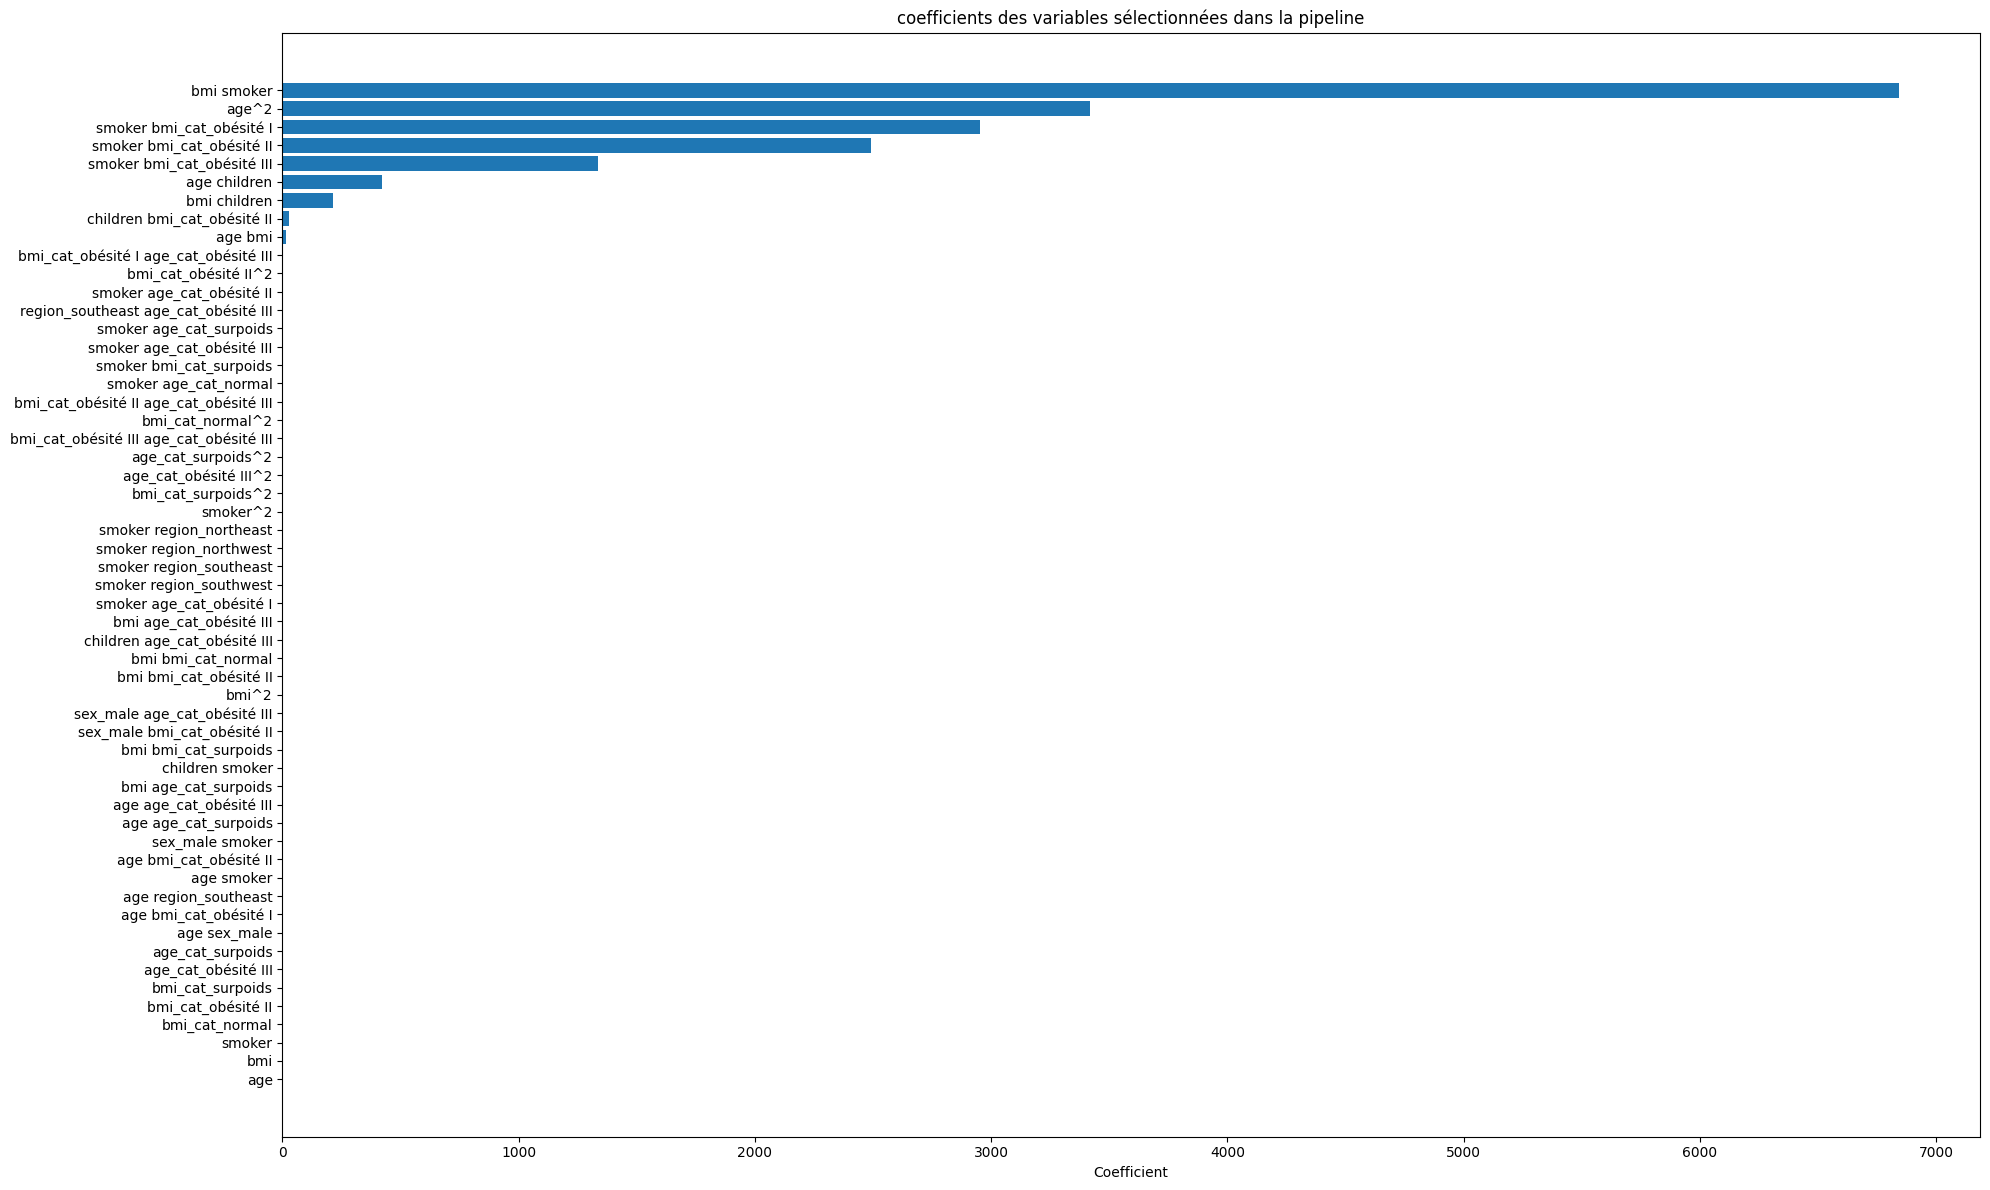

In [550]:
plt.figure(figsize=(20, 12))
plt.barh(pipeline_coef_df['feature'], pipeline_coef_df['coefficient'])
plt.title('coefficients des variables sélectionnées dans la pipeline')
plt.xlabel('Coefficient')
plt.tight_layout()
plt.show()


In [551]:
print("5 variables les plus importantes :")
print(pipeline_coef_df.tail())

5 variables les plus importantes :
                       feature  coefficient
39  smoker bmi_cat_obésité III  1337.159042
38   smoker bmi_cat_obésité II  2491.658541
37    smoker bmi_cat_obésité I  2954.342833
8                        age^2  3416.503107
23                  bmi smoker  6843.404788
